In [1]:
# Disable TensorFlow debugging info and warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 2: Info and warnings not displayed 

In [2]:
import numpy as np
import skimage.io
import skimage.exposure
import matplotlib.pyplot as plt
import matplotlib.colors
import pathlib
import tensorflow as tf
import tqdm
import annotation, misc, hyspec_io, image_render, hyspec_cnn, hyspec_ml
import sklearn.metrics

In [3]:
# Disable GPUs (in case of Tensorflow trying to use GPUs and raising errors)
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Paths
base_dir = pathlib.Path('/media/mha114/Massimal/Vega_Sola/Hyperspectral/20220823/Area')
val_im_dir = base_dir / '3a_PCA_TrainValidationSplit/Validation/PCA-Images'
water_mask_dir = base_dir / 'M_Annotation_WaterMask/20220823_VegaSola_WaterMask_Gray'
rgb_im_dir = base_dir / '2c_Rrs_RGB-WaterMask'
class_json_path = base_dir / '3a_PCA_TrainValidationSplit/Validation/Annotation/label_classes.json'
# unet_model_path = base_dir / 'M_UnetModels/Depth2/unet_model.epoch31-loss0.054138-acc0.770.hdf5'
# unet_model_path = base_dir / 'M_UnetModels/Depth3/unet_model.depth3.epoch16-loss0.052552-acc0.767.hdf5'
unet_model_path = base_dir / 'M_UnetModels/Depth2_Balanced/unet_model.depth2.epoch34-loss0.036197-acc0.834.hdf5'

fig_save_dir = base_dir / 'X_IGARSS_Figures'

In [5]:
# Parameters
PAD_MULTIPLE = 4

# Create custom colormap for classes (including background:0)
custom_cmap = matplotlib.colors.ListedColormap(colors=['darkgray',           # Background - darkgray 
                                                       'pink',         # Rock
                                                       'royalblue',       # Cobble
                                                       'darkturquoise',   # Sand
                                                       'magenta',         # Maerl bed
                                                       'seagreen',        # Rockweed
                                                       'darkorange',      # Kelp
                                                       'brown'])          # Brown algae

In [6]:
# Read annotation metadata file, show classes
class_dict = annotation.read_hasty_metadata(class_json_path)
for key,value in class_dict.items():
   print(f'{key}: {value}')

Rock: 1
Cobble: 2
Sand: 3
Mearl bed: 4
Rockweed: 5
Kelp: 6
Brown algae: 7


In [7]:
# Set plotting info based on class info
cbar_vmin = 0
cbar_vmax = max(class_dict.values())+1
cbar_ticks = [i+0.5 for i in range(cbar_vmax)]
cbar_ticklabels = ['Background']
for class_name in class_dict.keys():
    cbar_ticklabels.append(class_name)
cbar_ticklabels[4] = 'Maerl bed'
print(cbar_ticks)
print(cbar_ticklabels)

[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]
['Background', 'Rock', 'Cobble', 'Sand', 'Maerl bed', 'Rockweed', 'Kelp', 'Brown algae']


In [8]:
# Get dataset paths, load and merge datasets
val_image_paths = [path for path in sorted(val_im_dir.glob('*'))]
val_images = tf.data.Dataset.load(str(val_image_paths[0]))                # Load first image as initial dataset
for val_image_path in val_image_paths[1:]:                                # For every consecutive image,
    val_images = val_images.concatenate(tf.data.Dataset.load(str(val_image_path)))     # Append to dataset

In [9]:
# Create list of image names
image_names = [path.stem for path in val_image_paths]

In [10]:
# Pad to multiple 
pca_images = []
label_images = []
for pca_im, label_im in val_images.as_numpy_iterator():
    pca_images.append(hyspec_cnn.pad_image_to_multiple(pca_im,PAD_MULTIPLE))
    label_images.append(hyspec_cnn.pad_image_to_multiple(label_im,PAD_MULTIPLE))

In [11]:
# Load RGB_images
rgb_images = []
for image_name in image_names:
    rgb_im_path = [path for path in rgb_im_dir.rglob(image_name+'.bip.png')][0]
    rgb_im = skimage.io.imread(rgb_im_path)
    rgb_im_padded = hyspec_cnn.pad_image_to_multiple(rgb_im,PAD_MULTIPLE)
    rgb_images.append(rgb_im_padded)

In [12]:
# Create masks for valid data (water, not saturated)
valid_data_masks = []
for image_name, pca_im in zip(image_names,pca_images):
    water_mask_path = [path for path in water_mask_dir.rglob(image_name+'.bip.png')][0]
    water_mask = skimage.io.imread(water_mask_path)
    water_mask = hyspec_cnn.pad_image_to_multiple(water_mask,PAD_MULTIPLE) != 0
    nonzero_mask = ~np.all(pca_im==0,axis=2)
    valid_data_masks.append(water_mask*nonzero_mask)

In [13]:
# Load UNet model 
unet = tf.keras.models.load_model(unet_model_path)

In [14]:
# Predict labels for all images
label_images_pred = []
for pca_im in pca_images:
    label_images_pred.append(hyspec_cnn.unet_classify_single_image(unet,pca_im))

1/1 [==============================] - 2s 2s/step


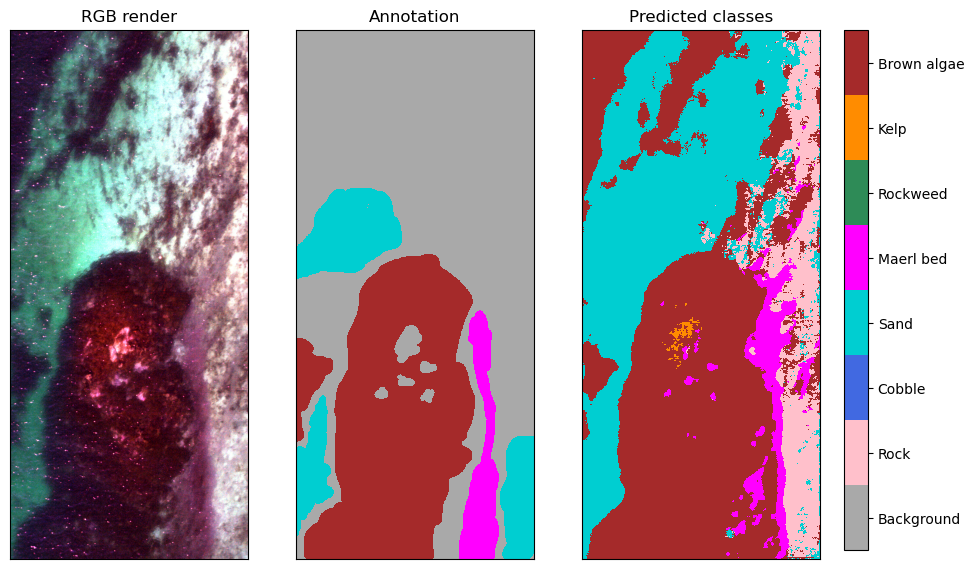

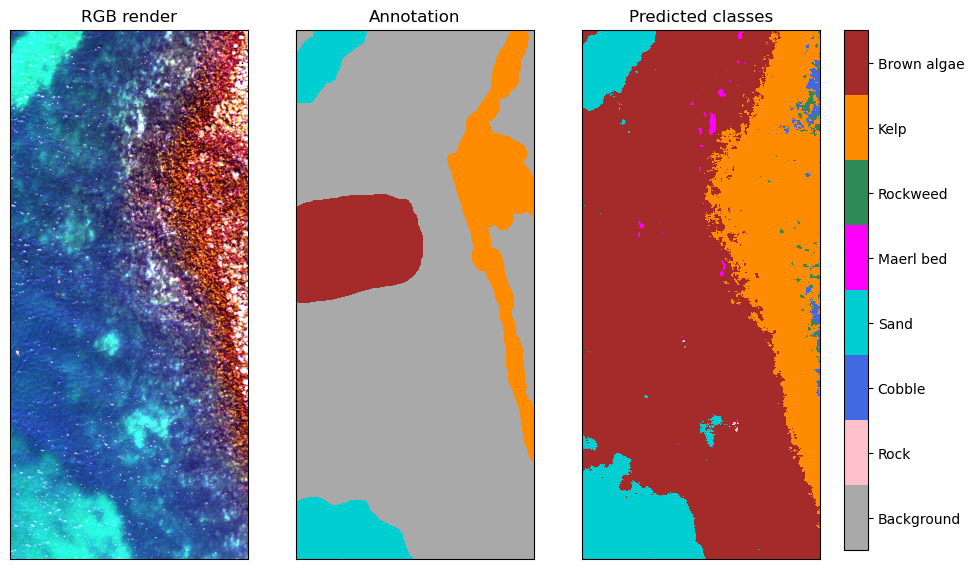

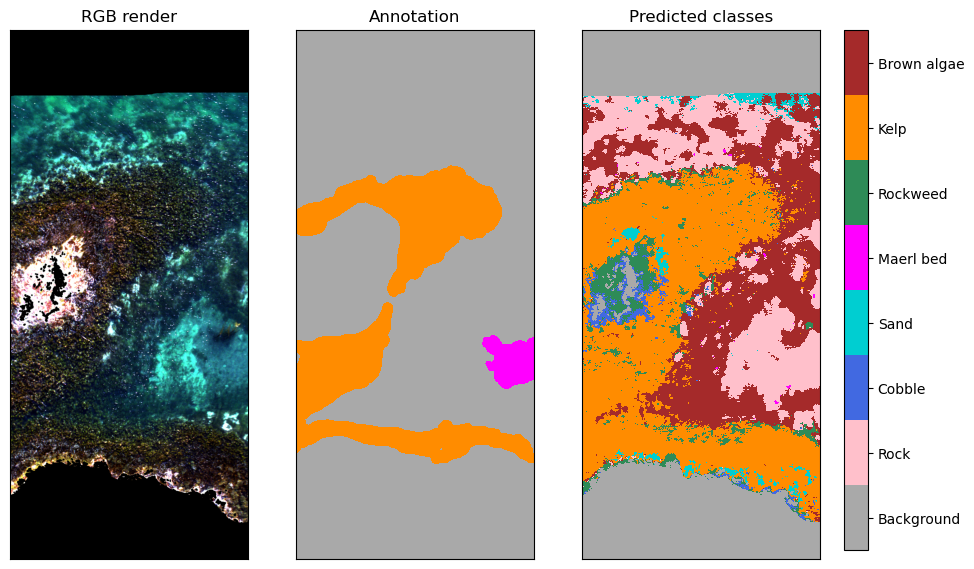

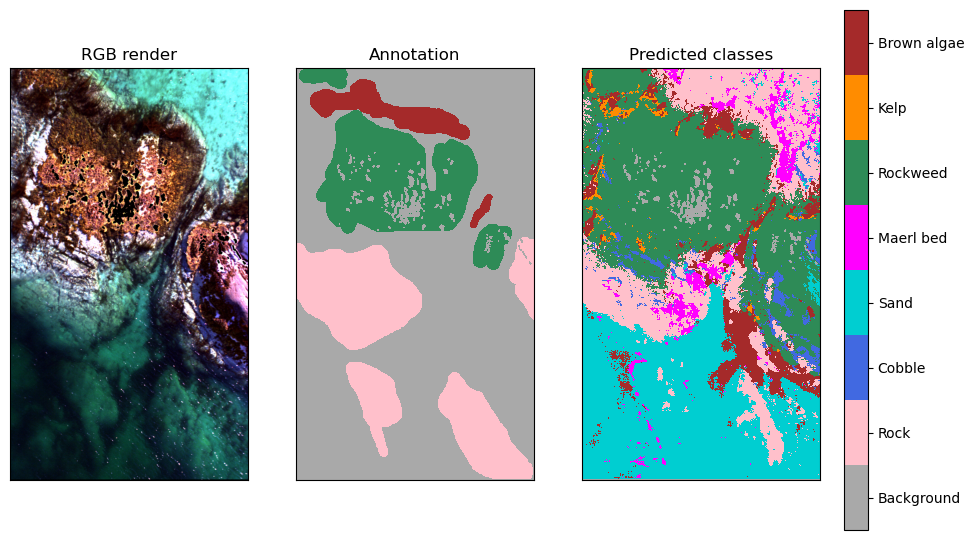

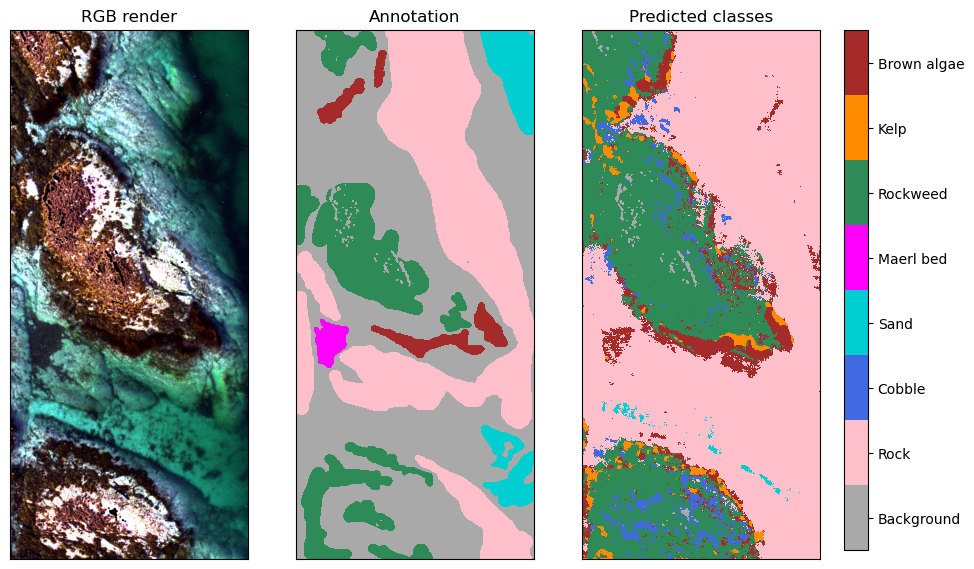

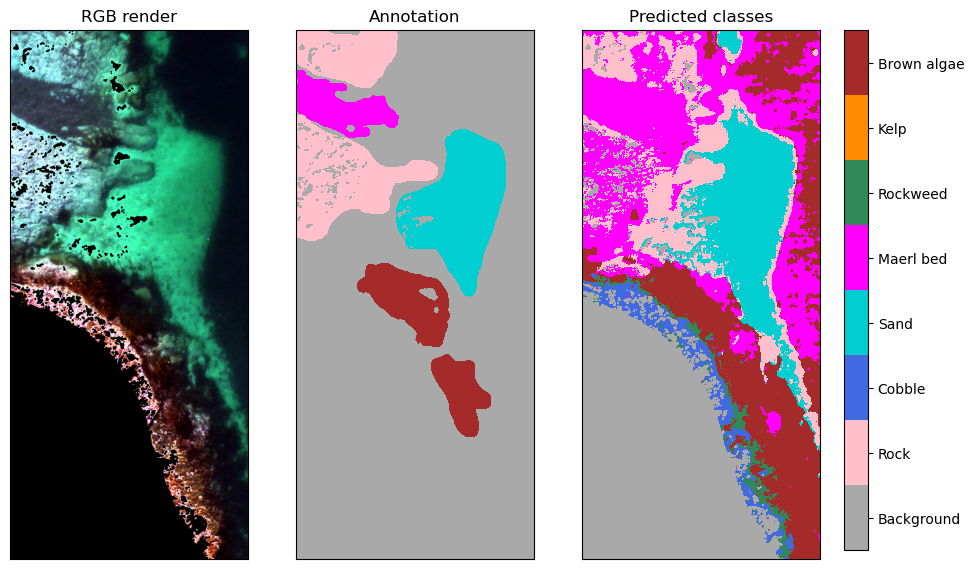

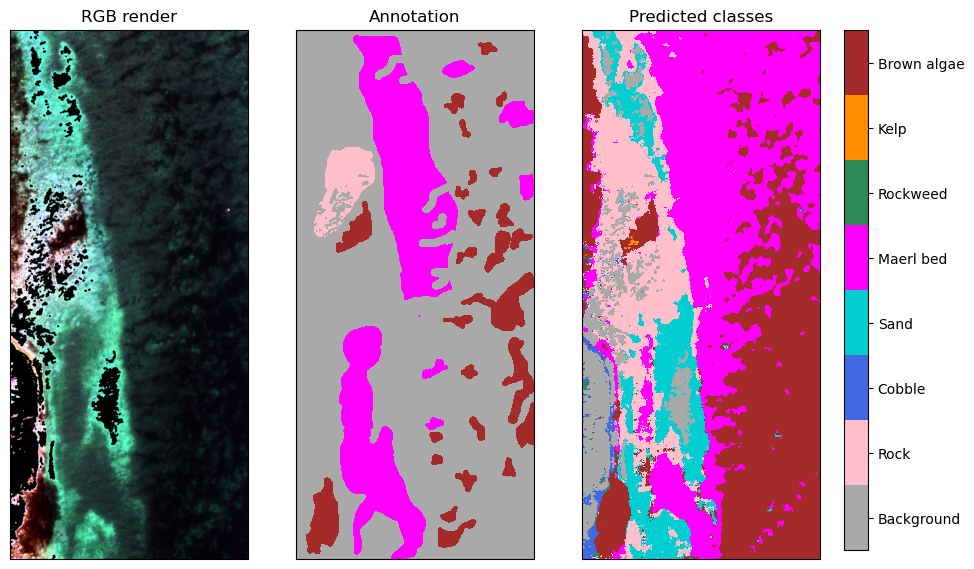

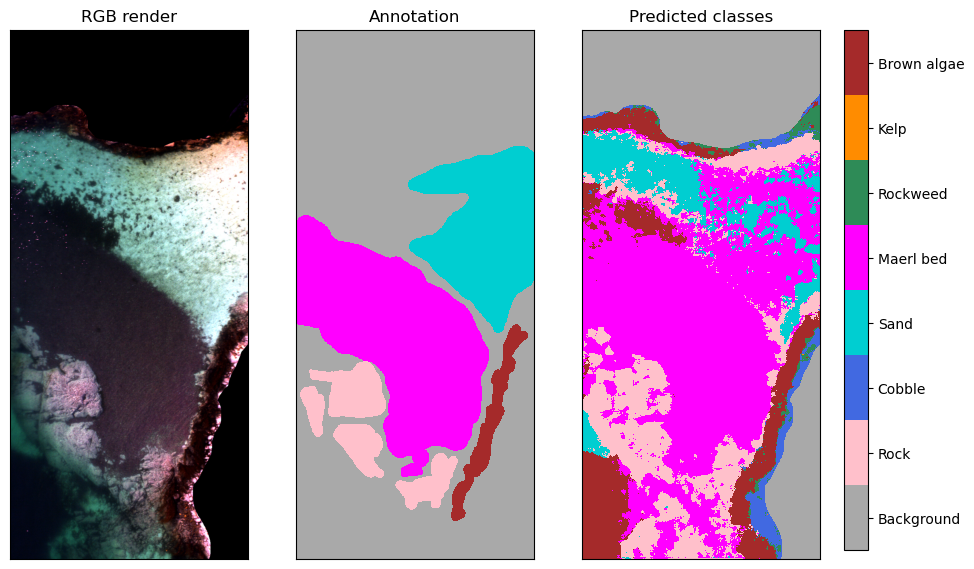

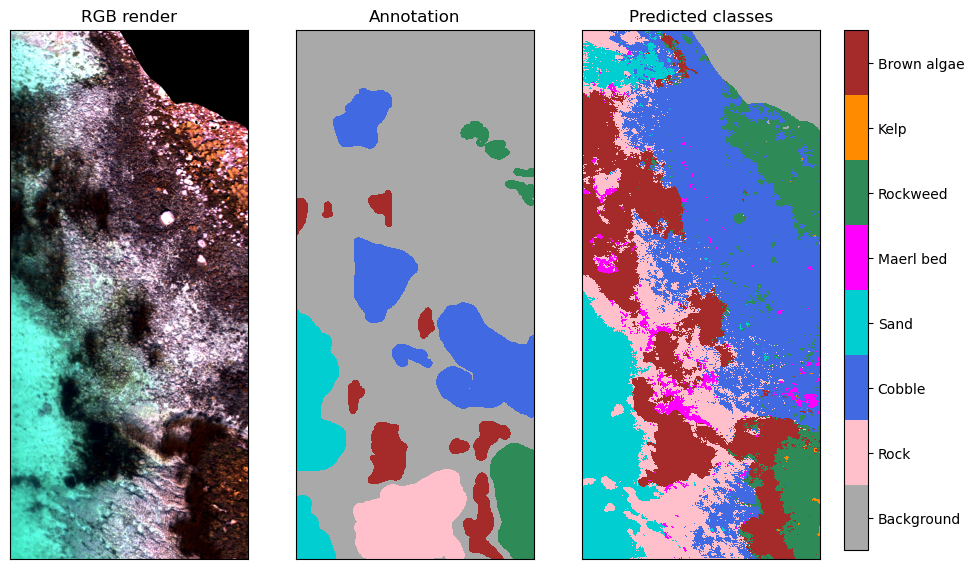

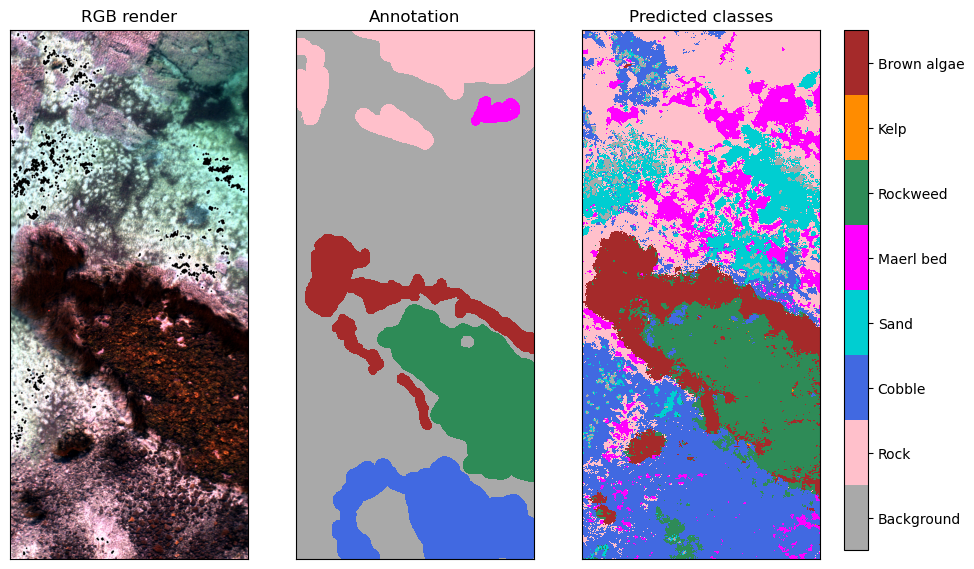

In [15]:
for rgb_im, valid_mask, label_im, label_im_pred,image_name in zip(
        rgb_images, valid_data_masks, label_images,label_images_pred,image_names):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=1,ncols=3,figsize=(12,8))
    im0 = ax0.imshow(rgb_im*np.expand_dims(valid_mask,axis=2))
    ax0.set_title('RGB render')
    im1 = ax1.imshow(label_im*valid_mask,cmap=custom_cmap,vmin=cbar_vmin,vmax=cbar_vmax,interpolation='none')
    ax1.set_title('Annotation')
    im2 = ax2.imshow(label_im_pred*valid_mask,cmap=custom_cmap,vmin=cbar_vmin,vmax=cbar_vmax,interpolation='none')
    ax2.set_title('Predicted classes')
    for ax in (ax0,ax1,ax2):
        ax.set_xticks([])
        ax.set_yticks([])
    fig.subplots_adjust(right=0.8)                   # Make room for colorbar
    cbar_ax = fig.add_axes([0.82, 0.175, 0.02, 0.65])  # [left, bottom, width, height] 
    cbar = fig.colorbar(im1, cax=cbar_ax)
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    plt.savefig(fig_save_dir/(image_name+'.png'),dpi=300,bbox_inches='tight')
    plt.show()

In [16]:
# Make confusion matrix based on test images
y_true = []
y_pred = []

for valid_mask, label_im, label_im_pred in zip(valid_data_masks, label_images,label_images_pred):
    annotated_mask = label_im != 0
    y_true.append(label_im[valid_mask*annotated_mask])
    y_pred.append(label_im_pred[valid_mask*annotated_mask])

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Remove zero-valued predictions (only very few). Odd - check out.
nonzero_pred = (y_pred != 0)
y_true = y_true[nonzero_pred]
y_pred = y_pred[nonzero_pred]

confusion_matrix = sklearn.metrics.confusion_matrix(y_true,y_pred,normalize='true')

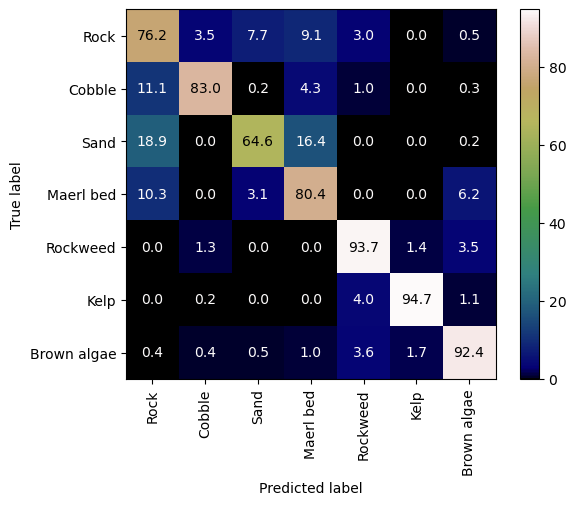

In [17]:
# Show confusion matrix
disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix*100,display_labels=cbar_ticklabels[1:])
disp.plot(xticks_rotation='vertical',cmap='gist_earth',values_format='.1f')
plt.savefig(fig_save_dir/'20220823_Vega_Sola_ConfusionMatrix.png',dpi=300,bbox_inches='tight')
plt.show()